# MMMI Oversight Script


CONFIGURATION FOR EXPERIMENTS

**TODO**: Easy testing of multiple memory parameters  ($p_1$,$\Delta_1$,$p_2$,$\Delta_2$ on the FinanceModel)

**TODO**: Varying the dividend rate

DUMMY MARKET

**TODO**: Make dummy market lognormal.

**TODO**: Double check dummy market calibration

**TODO**: Fit the dummy market to PNL data.

OTHER

**TODO**: track and display agent histories of consumption and earnings as well as dividend payouts.

**TODO**: Figure out a good way to compute "steady state"

**TODO**: Refactor main simulation loop to have 'days' on the outer loop

**TODO**: Reduce NL logging/warning in the notebook.

**TODO**: `requirements.txt`

**TODO**: Begin automated tests

**TODO**: How do deal with varying 'AdjustPrbs' in quarterly and daily solution steps.

**TODO**: Refactor code from AttentionSimulation to AgentPopulation as appropriate.



In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
from HARK.Calibration.Income.IncomeTools import (
     sabelhaus_song_var_profile,
)
import hark_portfolio_agents as hpa
import logging
import math
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Portfolio Consumption Model

The AttentionSimulation uses the Portfolio Consumption model from HARK.
The agent's resources unfold according to the following transition equations.

Variable | Equation | Operation | Stage | Utility
-- | -- | -- | -- | --
$\eta$ | ~Dist | Shock | c | --
$\theta$ | ~Dist | Shock | c | --
$\psi$ | ~Dist | Shock | c | --
$\hat{R}$ | $$\hat{R} = \alpha * R + (1 - \alpha) * R$$ | Update | c | --
b | $b_{t} = a_{t-1} \hat{R}$ | Update | c | --
p | $p_{t}=p_{t-1}\psi_{t}$ | Update | c | --
y | $y_{t} = p_{t}\theta _{t}$ | Update | c | --
m | $m_{t} = b_{t} + y_{t}$ | Update | c | --
c | c | Control | c | U(c)
a | $a_{t} = m_{t} - c_{t}$ | Update | portshare | --
$\alpha$ | $\alpha$ | Control | portshare | 0


## Initialize the Simulation

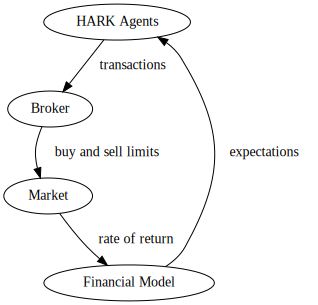

In [2]:
import graphviz as gv

dot = gv.Digraph(engine='dot')

dot.node('A', 'HARK Agents')
dot.node('B', 'Broker')
dot.node('M', 'Market')
dot.node('F', 'Financial Model')

dot.edge('A', 'B', label="transactions")
dot.edge('B', 'M', label="  buy and sell limits")
dot.edge('M', 'F', label="rate of return")
dot.edge('F', 'A', label="  expectations")

dot.format = 'png'

dot.render() 
            
dot


The AttentionSimulation class operates the "oversight code" with respect to four other simulation elements.

* HARK Agents - The consumers that earn, consume, and invest in the risky asset. When they have new targets for allocating their assets, they transact with the broker to buy or sell assets. They do this at the current 'market price'.
* Broker - Aggregates the consumer 
* Market - The PyNetLogo model of the Market, which takes the aggregate consumer demand and returns a rate of return.
* Financial Model - Computes the expectations of the risky asset from the rates of return history.

### Initialize agents to start

This is to set up the agent parameters and quantities used in the simulation.

`CRRA` refers to the `\rho` parameter in the constant relative risk aversion utility function used by the agents. Utility is over units of resources consumed.

`aNrmInitStd` is normalized initial market assets, standard deviation. The agents' starting wealth is drawn from a lognormal distribution with this standard deviation.

`pLvlInitMean` and `pLvlInitStd` are the mean and standard deviation of the initial level of permanent income of the agents.

In [3]:
import math

dist_params = {
    'CRRA' : {'bot' : 2, 'top' : 10, 'n' : 2}, # Chosen for "interesting" results
    'DiscFac' : {'bot' : 0.936, 'top' : 0.978, 'n' : 2} # from CSTW "MPC" results
}

# Get empirical data from Sabelhaus and Song
ssvp = sabelhaus_song_var_profile()

# Assume all the agents are 40 for now.
# We will need to make more coherent assumptions about the timing and age of the population later.
# Scaling from annual to quarterly
idx_40 = ssvp['Age'].index(40)

### parameters shared by all agents
agent_parameters = {
    'aNrmInitStd' : 0.0,
    'LivPrb' : [0.98 ** 0.25],
    'PermGroFac': [1.01 ** 0.25],
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0,
    'Rfree' : 1.0,
    'TranShkStd' : [ssvp['TranShkStd'][idx_40] / 2],  # Adjust non-multiplicative shock to quarterly
    'PermShkStd' : [ssvp['PermShkStd'][idx_40] ** 0.25]
}

## Run the main loop



In [4]:
def run_simulation(agent_parameters, dist_params, n_per_class, a = None, q = None, r = 1, fm = None, market = None):
    
    # initialize population
    pop = hpa.AgentPopulation(agent_parameters, dist_params, 5)
    
    # Initialize the financial model
    fm = hpa.FinanceModel() if fm is None else fm

    fm.calculate_risky_expectations()
    agent_parameters.update(fm.risky_expectations())

    # Initialize the population model
    pop.init_simulation()
    
    attsim = hpa.AttentionSimulation(pop, fm, a = a, q = q, r = r, market = market)
    attsim.simulate()
    
    return attsim.sim_stats()

In [5]:
sim_stats = run_simulation(agent_parameters, dist_params, 2, a = 0.2, q = 2)

config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
Q-0
Q-0:R-0
Buy/Sell Limit: (0, 0)
Output for S:7,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Q-1
Q-1:R-0


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (12, 8)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL12SL8.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5

Elapsed (sys clock), run 2:  56.192922376
ror: 0.010361638970588236


In [6]:
sim_stats

{('aLvl_mean', 'CRRA: 4.0, DiscFac: 0.95'): 1.8897939485773438,
 ('aLvl_mean', 'CRRA: 4.0, DiscFac: 0.97'): 1.8910708708861717,
 ('aLvl_mean', 'CRRA: 8.0, DiscFac: 0.95'): 2.371922548860911,
 ('aLvl_mean', 'CRRA: 8.0, DiscFac: 0.97'): 2.202594022375962,
 ('aLvl_std', 'CRRA: 4.0, DiscFac: 0.95'): 0.12728875244380794,
 ('aLvl_std', 'CRRA: 4.0, DiscFac: 0.97'): 0.2047487437511851,
 ('aLvl_std', 'CRRA: 8.0, DiscFac: 0.95'): 0.26649488684908906,
 ('aLvl_std', 'CRRA: 8.0, DiscFac: 0.97'): 0.2572863556172734,
 'attention': 0.2,
 'ror_volatility': 0.002212916244741972}

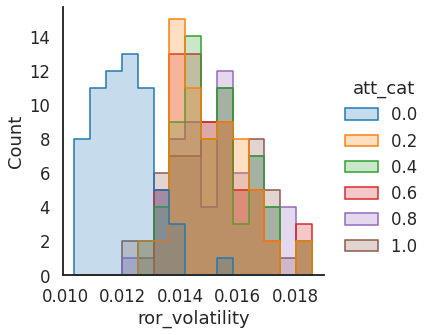

In [7]:
import seaborn as sns

data = pd.read_csv("study.csv")

data["att_cat"] = data['attention'].apply(lambda x: str(x) + ' ')

sns.displot(
    data, 
    x="ror_volatility", 
    hue="att_cat", 
    element='step'
)

In [8]:
data.groupby('attention').mean()

,Unnamed: 0,"('aLvl_mean', 'CRRA: 4.0, DiscFac: 0.95')","('aLvl_mean', 'CRRA: 4.0, DiscFac: 0.97')","('aLvl_mean', 'CRRA: 8.0, DiscFac: 0.95')","('aLvl_mean', 'CRRA: 8.0, DiscFac: 0.97')",ror_volatility
attention,,,,,,
0.0,31.5,1.108340,1.123238,1.494590,1.504935,0.012029
0.2,31.5,0.961770,0.968750,1.287463,1.270053,0.015060
0.4,31.5,0.910535,0.924204,1.211349,1.215943,0.015112
0.6,31.5,0.921881,0.946052,1.225594,1.236362,0.015061
0.8,31.5,0.912436,0.902388,1.225313,1.215148,0.015384
1.0,31.5,0.893802,0.894850,1.185514,1.168316,0.015260


In [9]:
data


,Unnamed: 0,"('aLvl_mean', 'CRRA: 4.0, DiscFac: 0.95')","('aLvl_mean', 'CRRA: 4.0, DiscFac: 0.97')","('aLvl_mean', 'CRRA: 8.0, DiscFac: 0.95')","('aLvl_mean', 'CRRA: 8.0, DiscFac: 0.97')",attention,ror_volatility,att_cat
0,0,1.041349,1.069141,1.294754,1.308352,0.0,0.010810,0.0
1,1,1.240998,1.245416,1.708920,1.748958,0.0,0.012321,0.0
2,2,1.035535,1.037534,1.365126,1.144461,0.0,0.012386,0.0
3,3,1.185968,1.197765,1.646860,1.623401,0.0,0.012371,0.0
4,4,1.214019,1.250709,1.702823,1.711721,0.0,0.012549,0.0
...,...,...,...,...,...,...,...,...
379,59,1.030721,0.797290,1.076565,1.061533,1.0,0.014598,1.0
380,60,0.403628,0.528600,0.595776,0.696649,1.0,0.016064,1.0
381,61,0.509063,0.541318,0.696898,0.713784,1.0,0.014261,1.0
382,62,0.865811,0.691432,0.952598,0.963519,1.0,0.015762,1.0


In [10]:
#print(records_1)

In [11]:
#records_1 is None

In [12]:
data

,Unnamed: 0,"('aLvl_mean', 'CRRA: 4.0, DiscFac: 0.95')","('aLvl_mean', 'CRRA: 4.0, DiscFac: 0.97')","('aLvl_mean', 'CRRA: 8.0, DiscFac: 0.95')","('aLvl_mean', 'CRRA: 8.0, DiscFac: 0.97')",attention,ror_volatility,att_cat
0,0,1.041349,1.069141,1.294754,1.308352,0.0,0.010810,0.0
1,1,1.240998,1.245416,1.708920,1.748958,0.0,0.012321,0.0
2,2,1.035535,1.037534,1.365126,1.144461,0.0,0.012386,0.0
3,3,1.185968,1.197765,1.646860,1.623401,0.0,0.012371,0.0
4,4,1.214019,1.250709,1.702823,1.711721,0.0,0.012549,0.0
...,...,...,...,...,...,...,...,...
379,59,1.030721,0.797290,1.076565,1.061533,1.0,0.014598,1.0
380,60,0.403628,0.528600,0.595776,0.696649,1.0,0.016064,1.0
381,61,0.509063,0.541318,0.696898,0.713784,1.0,0.014261,1.0
382,62,0.865811,0.691432,0.952598,0.963519,1.0,0.015762,1.0
